### EXP: Pilote2 QC rating 

- **Aim:** First attempt of assesing quality control (QC) of brain registration on the Zooniverse platform. Raters are some of zooniverse users who agreed to test new projects and give feedback ( ref: https://www.zooniverse.org/projects/simexp/brain-match ).

- **Exp:** 
    - We choose 100 anatomical brain images (?? OK, ?? Maybe and ?? Fail)   preprocced with NIAK pipelines from ADHD200 datsets.
    - We asked raters on the Zooniverse platform to QC images based on the tutorial and the rated sample images.

In [1]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

In [3]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [4]:
# Read raw table
classifications = pd.read_csv('../data/rating/brain-match-classifications-12-10-2018.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [5]:
# List all workflows 
classifications.workflow_version.unique()

array([12.12, 12.13,  1.2 , 12.2 , 14.28,  1.9 , 14.3 ,  1.12,  1.1 ,
       16.1 , 16.2 ,  1.3 , 18.2 ,  2.3 ,  1.27,  2.6 ,  2.7 ,  2.12])

In [6]:
# Filter out only specific workflow
ratings = classifications.loc[classifications['workflow_name'].isin(['Spot anatomical differences']) &
                             classifications['workflow_version'].isin(['14.3'])]
ratings.count()

classification_id    1365
user_name            1365
user_id               988
user_ip              1365
workflow_id          1365
workflow_name        1365
workflow_version     1365
created_at           1365
gold_standard           0
expert                  0
metadata             1365
annotations          1365
subject_data         1365
subject_ids          1365
dtype: int64

In [7]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[1]['value']) for q in ratings.annotations]
# extract rating count
ratings.loc[:,"rating"] = [ q[0]['value'] for q in ratings.annotations]
# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids[ind])]['subject_ID'] for ind,row in ratings.iterrows()]
# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids[ind])]['images'] for ind,row in ratings.iterrows()]

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
# How many rating per user
user_count = ratings.user_name.value_counts()
user_count

EcceruElme                            58
KazzaY                                46
Dennis21                              41
asko_oksa                             30
not-logged-in-064781f2567efce122db    28
Liisika                               23
cyerby                                21
WEBs_in_space                         19
Chris5420                             19
CDawgUnleashed                        19
MishySee                              17
Kroth                                 17
not-logged-in-73c860b38b85defd0805    16
jschott5                              16
nhaberman                             16
Lostasagoose                          16
not-logged-in-68dd3f93fae58eff8a53    15
ReggieMcintosh                        14
141Dial34                             13
sapphira80                            13
not-logged-in-bf3e439ee2f80b8bef3a    13
not-logged-in-ded933a4b119ccaefd6a    13
DFK1951                               12
Ptd                                   12
Manny936        

In [9]:
#select only users that have rated a certain ammount of images 
list_user = user_count.index
list_user = list_user[user_count.values>10]
user_count[list_user]

EcceruElme                            58
KazzaY                                46
Dennis21                              41
asko_oksa                             30
not-logged-in-064781f2567efce122db    28
Liisika                               23
cyerby                                21
WEBs_in_space                         19
Chris5420                             19
CDawgUnleashed                        19
MishySee                              17
Kroth                                 17
not-logged-in-73c860b38b85defd0805    16
jschott5                              16
nhaberman                             16
Lostasagoose                          16
not-logged-in-68dd3f93fae58eff8a53    15
ReggieMcintosh                        14
141Dial34                             13
sapphira80                            13
not-logged-in-bf3e439ee2f80b8bef3a    13
not-logged-in-ded933a4b119ccaefd6a    13
DFK1951                               12
Ptd                                   12
Manny936        

In [10]:
# remove users with less rating then the selected threshold
ratings = ratings[ratings.user_name.isin(list_user)]
ratings.count()

classification_id    611
user_name            611
user_id              503
user_ip              611
workflow_id          611
workflow_name        611
workflow_version     611
created_at           611
gold_standard          0
expert                 0
metadata             611
annotations          611
subject_data         611
subject_ids          611
n_tagging            611
rating               611
ID                   611
imgnm                611
dtype: int64

In [11]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

not-logged-in-bff2d9caebce8b749a95 have 2 duplicated ratings
nhaberman have 2 duplicated ratings
not-logged-in-bf3e439ee2f80b8bef3a have 6 duplicated ratings
not-logged-in-064781f2567efce122db have 8 duplicated ratings
kryswolf have 2 duplicated ratings
sapphira80 have 3 duplicated ratings
Liisika have 3 duplicated ratings
asko_oksa have 20 duplicated ratings
ReggieMcintosh have 3 duplicated ratings
not-logged-in-ded933a4b119ccaefd6a have 3 duplicated ratings
Manny936 have 1 duplicated ratings
cyerby have 1 duplicated ratings
not-logged-in-3085bc192f4ce6d18fcf have 1 duplicated ratings
Dennis21 have 21 duplicated ratings
Total number of duplicated ratings  = 76


In [12]:
# Get the final rating numbers per subject
user_count = classi_unique.user_name.value_counts()
user_count

EcceruElme                            58
KazzaY                                46
not-logged-in-064781f2567efce122db    20
cyerby                                20
Liisika                               20
Dennis21                              20
Chris5420                             19
WEBs_in_space                         19
CDawgUnleashed                        19
Kroth                                 17
MishySee                              17
not-logged-in-73c860b38b85defd0805    16
jschott5                              16
Lostasagoose                          16
not-logged-in-68dd3f93fae58eff8a53    15
nhaberman                             14
141Dial34                             13
OldWoodchuck                          12
joncarruthers                         12
DFK1951                               12
Ptd                                   12
Manny936                              11
elainelwright                         11
MBeeHH                                11
anne_vincent_64 

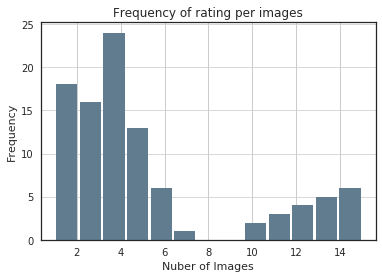

In [13]:
# plot rating per image distribution
image_count = classi_unique.subject_ids.value_counts()
image_count.plot.hist(grid=True,rwidth=0.9, bins=13,color='#607c8e')
plt.title('Frequency of rating per images')
plt.xlabel('Nuber of Images')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [14]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
df_ratings.head()

,ID,EcceruElme,KazzaY,not-logged-in-064781f2567efce122db,cyerby,Liisika,Dennis21,Chris5420,WEBs_in_space,CDawgUnleashed,...,MBeeHH,anne_vincent_64,ReggieMcintosh,asko_oksa,not-logged-in-bff2d9caebce8b749a95,not-logged-in-ded933a4b119ccaefd6a,kryswolf,not-logged-in-3085bc192f4ce6d18fcf,sapphira80,not-logged-in-bf3e439ee2f80b8bef3a
0,X0010031,Fail,OK,Fail,Maybe,Fail,OK,NaN,NaN,NaN,...,NaN,OK,NaN,OK,NaN,NaN,OK,NaN,OK,NaN
1,X8432725,Fail,NaN,NaN,NaN,NaN,NaN,OK,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,X0026022,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,X3809753,Fail,OK,Maybe,OK,Maybe,OK,Fail,NaN,NaN,...,NaN,NaN,Maybe,NaN,NaN,Fail,NaN,OK,NaN,NaN
4,X2136051,Fail,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# remove duplicates
df_ratings = df_ratings[~df_ratings.ID.duplicated()]

### Explore the concensus of rating between images

In [80]:
# Get ratings from images rated more tan N different rates 
n = 4 # Minimun number of ratings per image
stuff = np.array([[row.ID,
                   np.sum(row[1:-1].values=='Fail'),
                   np.sum(row[1:-1].values=='Maybe'),
                   np.sum(row[1:-1].values=='OK')]  
                  for ind, row in df_ratings.iterrows() if np.sum([np.sum(row[1:-1].values=='Fail'),
                                                                 np.sum(row[1:-1].values=='Maybe'),
                                                                 np.sum(row[1:-1].values=='OK')]) >= n])
df_score = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
df_score.head()

,ID,Fail,Maybe,OK
0,X0010031,6,1,6
1,X3809753,3,4,6
2,X0026002,2,1,1
3,X0010049,3,4,5
4,X2961243,2,2,1


In [81]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'max_value_NoExp'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'concensus_NoExp'] = max_rate
df_norm.head()

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
0,X0010031,0.461538,0.0769231,0.461538,0.461538,Fail
1,X3809753,0.230769,0.307692,0.461538,0.461538,OK
2,X0026002,0.5,0.25,0.25,0.500000,Fail
3,X0010049,0.25,0.333333,0.416667,0.416667,OK
4,X2961243,0.4,0.4,0.2,0.400000,Fail


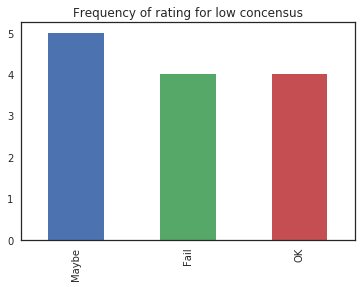

In [82]:
count_ = df_norm.concensus_NoExp[[0 <= row.max_value_NoExp < 0.5   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for low concensus')

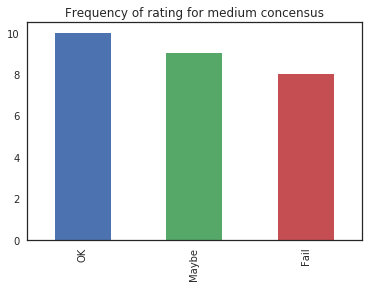

In [83]:
count_ = df_norm.concensus_NoExp[[0.5 <= row.max_value_NoExp < 0.65   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for medium concensus')

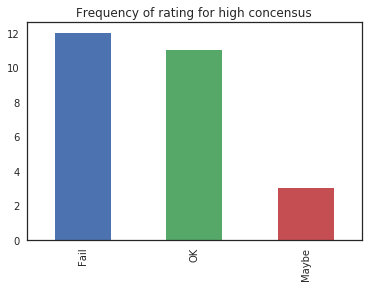

In [84]:
count_ = df_norm.concensus_NoExp[[0.6 < row.max_value_NoExp <= 1   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for high concensus')

### Merge Pilot2 and Beta1 rating and get Kappa score

In [85]:
pilot2 = pd.read_csv('../data/rating/Pilot2_internal_rating-PB_YB.csv')
pilot2.head()

,ID,YB,PB
0,X4104523,Fail,Maybe
1,X0010052,OK,Maybe
2,X3107623,OK,OK
3,X1962503,Maybe,Maybe
4,X0010032,Fail,Fail


In [92]:
# Merge 
merge_ratings = pd.merge(pilot2,df_norm[['ID','concensus_NoExp']],on='ID',how='inner')
merge_ratings.rename(columns={'concensus_NoExp':'Beta1'},inplace=True)
merge_ratings.head()

,ID,YB,PB,Beta1
0,X4104523,Fail,Maybe,Fail
1,X0010052,OK,Maybe,Maybe
2,X3107623,OK,OK,OK
3,X0010032,Fail,Fail,Fail
4,X3433846,Maybe,OK,Fail


In [93]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
merge_ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
merge_ratings.head()

,ID,YB,PB,Beta1
0,X4104523,3,2,3
1,X0010052,1,2,2
2,X3107623,1,1,1
3,X0010032,3,3,3
4,X3433846,2,1,3


In [94]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

In [95]:
# Percenteage of agrrement between raters with R package IRR
agree_ = merge_ratings[['PB','YB','Beta1']]
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 30 
   Raters = 3 
  %-agree = 43.3 



In [97]:
def kappa_score(k_df ):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            %Rpush user1_id user1 user2_id user2
            kappaR =  %R kappa2(k_df[,c(user1,user2)],c(0,1,2))
            #kappa = metrics.cohen_kappa_score(list(k_df[user1]),list(k_df[user2]))
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
    return k_store, p_store

In [100]:
# Get Kappa score out of all different combination of ratings
kappa_df  = merge_ratings[['PB','YB','Beta1']]
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.50 , std : 0.11

 Fleiss' Kappa for m Raters

 Subjects = 30 
   Raters = 3 
    Kappa = 0.398 

        z = 5.33 
  p-value = 9.78e-08 



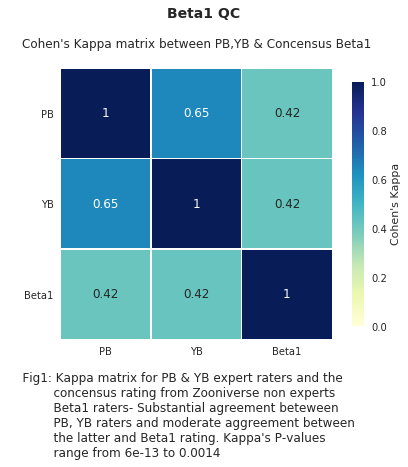

In [114]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (7,5))
f.subplots_adjust(hspace= .8)

f.suptitle('Beta1 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix between PB,YB & Concensus Beta1",pad=20,fontsize=12)

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for PB & YB expert raters and the 
            concensus rating from Zooniverse non experts 
            Beta1 raters- Substantial agreement beteween 
            PB, YB raters and moderate aggreement between 
            the latter and Beta1 rating. Kappa's P-values 
            range from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(.1,-0.2,txt,fontsize=12)
# Save figure
f.savefig('../reports/figures/Beta1_qc.svg')

In [115]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

### Report tagging from Beta1 raters

In [26]:
# output markings from classifications
clist=[]
for index, c in classi_unique.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[1]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'1.5','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out_tag = pd.DataFrame(clist)[col_order]
out_tag.user_name.replace({'simexp':'PB','Yassinebha':'YB'},inplace=True)
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X0021010,Spot anatomical differences,joncarruthers,OK,NaN,NaN,NaN,0,summary_X0021010_anat2template.gif,1
1,X3848511,Spot anatomical differences,joncarruthers,Fail,333.5,102.0,1.5,2,summary_X3848511_anat2template.gif,0
2,X3848511,Spot anatomical differences,joncarruthers,Fail,302.5,106.0,1.5,2,summary_X3848511_anat2template.gif,0
3,X2054998,Spot anatomical differences,joncarruthers,Maybe,220.5,184.0,1.5,2,summary_X2054998_anat2template.gif,0
4,X2054998,Spot anatomical differences,joncarruthers,Maybe,188.5,184.0,1.5,2,summary_X2054998_anat2template.gif,0


In [27]:
# Extract unique IDs for each image
ids_imgnm = np.reshape([out_tag.ID.unique(),out_tag.imgnm.unique()],(2,np.shape(out_tag.ID.unique())[0]))
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])
df_ids_imgnm.head()

,ID,imgnm
0,X0010003,summary_X0010003_anat2template.gif
1,X0010007,summary_X0010007_anat2template.gif
2,X0010009,summary_X0010009_anat2template.gif
3,X0010013,summary_X0010013_anat2template.gif
4,X0010029,summary_X0010029_anat2template.gif


In [28]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap , ListedColormap
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)


coll,a=_cmap_from_image_path('../data/Misc/custom_ColBar.png')
#invert color map
coll_r = ListedColormap(coll[::-1])

In [30]:
# set color different for each rater
list_tagger = out_tag.user_name.unique()
colors_tagger = sns.color_palette("Set2", len(list_tagger))

### Plot heat map for all tagging

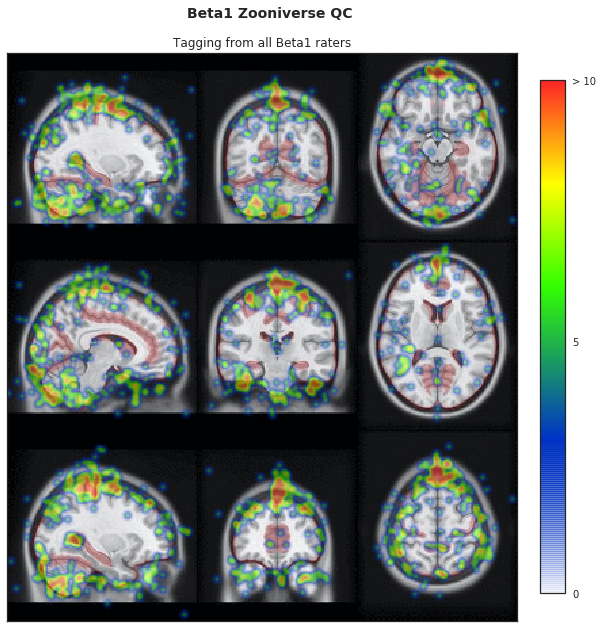

In [52]:
from heatmappy import Heatmapper
from PIL import Image

patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row.x,row.y) for ind,row in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Beta1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v1.png')
axes.set_title('Tagging from all Beta1 raters')

heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=10,
                        point_strength = 0.5,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patches, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '5', '> 10'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Beta1_qc_heatmap_tags.svg')